<a href="https://colab.research.google.com/github/jihyeon602/DeepLearning_practice/blob/main/artist_cls_keras_quiz_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#You can import other libraries if you want

In [ ]:
!pip install tensorflow

In [ ]:
#If it is not installed in your environment

In [ ]:
###### DO NOT MODIFY THIS PART
seed = 2024
os.environ['PYTHONHASHSEED'] = str(seed) # fix your random seed : In same model, you produce the same result
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
######

In [ ]:
artists = pd.read_csv('/content/artists_train.csv') # your own directory, artists.csv
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe
artists_top = artists[artists['paintings'] >= 0].reset_index()
artists_top = artists_top[['name', 'paintings']]

updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [ ]:
!unzip -q /content/art-20250420T141430Z-001.zip -d /content/art/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Explore images of top artists
images_dir =  '/content/art/art/train'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').str.replace('ü', 'u').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):  # images_idr: directory folder // name: label (y)
        print("find -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

find --> /content/art/art/train/Vincent_van_Gogh
find --> /content/art/art/train/Edgar_Degas
find --> /content/art/art/train/Pablo_Picasso
find --> /content/art/art/train/Pierre-Auguste_Renoir
find --> /content/art/art/train/Albrecht_Durer
find --> /content/art/art/train/Paul_Gauguin
find --> /content/art/art/train/Francisco_Goya
find --> /content/art/art/train/Rembrandt
find --> /content/art/art/train/Alfred_Sisley
find --> /content/art/art/train/Titian
find --> /content/art/art/train/Marc_Chagall


In [ ]:
batch_size = 64
img_height = 244
img_width = 244
input_shape = (img_height, img_width)
n_classes = 11
classes = ['Vincent_van_Gogh', 'Edgar_Degas', 'Pablo_Picasso', 'Pierre-Auguste_Renoir',
    'Albrecht_Durer', 'Paul_Gauguin', 'Francisco_Goya', 'Rembrandt',
    'Alfred_Sisley', 'Titian', 'Marc_Chagall']

#Image data generate with validation data fraction of 0.2 and data rescale 1/255.
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                  )  #데이터 실시간 로딩
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory='/content/art/art/train',
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory='/content/art/art/val',
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=False,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 2470 images belonging to 11 classes.
Found 152 images belonging to 11 classes.
Total number of batches = 38 and 2


In [ ]:
image, label = next(iter(train_generator))
image.shape, label.shape

((64, 244, 244, 3), (64, 11))

In [ ]:
#######################
# Make your own model #
#######################
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16

img_height = 244
img_width = 244
#num_classes = len(classes) # img_height, img_width
num_classes = 11


In [ ]:
'''
과적합
from tensorflow.keras.callbacks import EarlyStopping

# 모델 정의
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # num_classes는 11
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',        # 검증 손실 기준
    patience=5,                # 개선 없으면 5 epoch 후 중단
    restore_best_weights=True # 가장 성능 좋았던 가중치 복원
)

#training
n_epoch = 15 #10~15로 줄이기
history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                              validation_data=valid_generator, validation_steps=len(valid_generator),
                              epochs=n_epoch, callbacks=[early_stop]) #you can add kwargs if you want

print(f"Training complete with final accuracy: {history.history['accuracy'][-1]}")
'''

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
import pickle
import os

from google.colab import drive
drive.mount('/content/drive')

# Residual Block
@register_keras_serializable()  # 로딩
class ResidualBlock(Model):
    def __init__(self, num_kernels, kernel_size, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size

        self.conv1 = layers.Conv2D(num_kernels, kernel_size=kernel_size, padding="same", activation="relu")
        self.conv2 = layers.Conv2D(num_kernels, kernel_size=kernel_size, padding="same", activation="relu")
        self.add = layers.Add()
        self.relu = layers.Activation("relu")
        self.projection = None

    def build(self, input_shape):
        input_channels = input_shape[-1]
        if input_channels != self.num_kernels:
            self.projection = layers.Conv2D(self.num_kernels, kernel_size=(1, 1), padding="same")
        else:
            self.projection = lambda x: x

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        shortcut = self.projection(input_tensor)
        x = self.add([x, shortcut])
        return self.relu(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_kernels": self.num_kernels,
            "kernel_size": self.kernel_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# ResNet 모델
def build_resnet(input_shape, num_classes):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(ResidualBlock(128, (3, 3)))
    model.add(ResidualBlock(128, (3, 3)))
    model.add(ResidualBlock(128, (3, 3)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def main():
    input_shape = (244, 244, 3)
    num_classes = 11
    n_epoch = 50

    model = build_resnet(input_shape, num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        epochs=n_epoch,
        callbacks=[early_stop]
    )

    model_dir = '/content/drive/MyDrive/keras_clf2'
    os.makedirs(model_dir, exist_ok=True)

    model.save(os.path.join(model_dir, 'my_model.keras'))

    with open(os.path.join(model_dir, 'history.pkl'), 'wb') as f:
        pickle.dump(history.history, f)

    print(f"Training complete with final accuracy: {history.history['accuracy'][-1]:.4f}")
    print("History keys:", history.history.keys())
    print("Final training history:", history.history)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2061 - loss: 2.2476 - val_accuracy: 0.2566 - val_loss: 2.0541
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 75s 888ms/step - accuracy: 0.2924 - loss: 1.9368 - val_accuracy: 0.3158 - val_loss: 1.9292
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 924ms/step - accuracy: 0.3549 - loss: 1.7873 - val_accuracy: 0.3816 - val_loss: 1.8717
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 905ms/step - accuracy: 0.3679 - loss: 1.7725 - val_accuracy: 0.3158 - val_loss: 1.8203
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 910ms/step - accuracy: 0.3887 - loss: 1.6859 - val_accuracy: 0.3289 - val_loss: 1.8084
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 926ms/step - accuracy: 0.3985 - loss: 1.6522 - val_accuracy: 0.4737 - val_loss: 1.6092
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 927ms/step - accuracy: 0.4509 - loss: 1.5813 - val_accurac

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


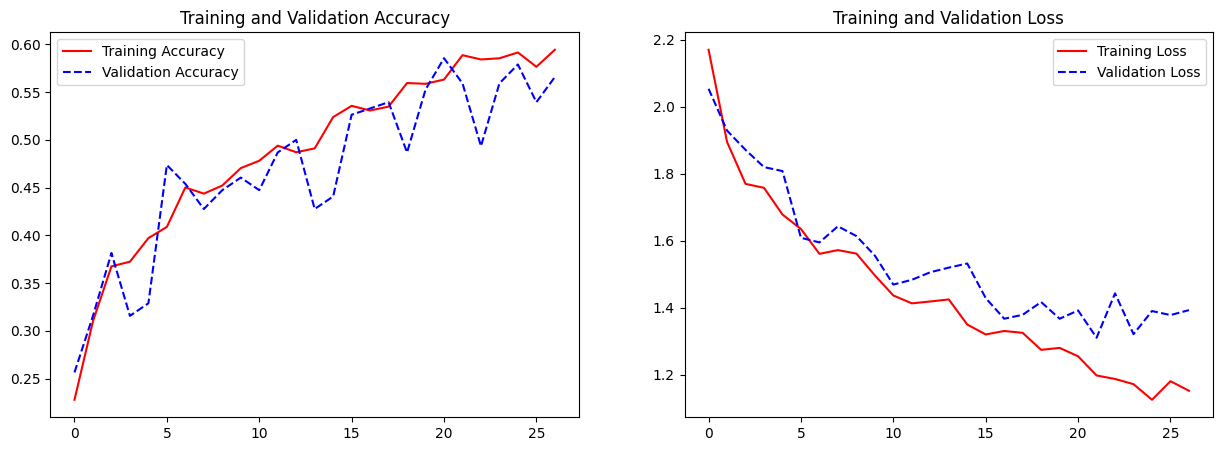

In [ ]:
import matplotlib.pyplot as plt

history_file_path = '/content/drive/MyDrive/keras_clf2/history.pkl'
with open(history_file_path, 'rb') as f:
    history = pickle.load(f)

his = history.keys()
print(his)

his = dict()

his['loss'] = history['loss']
his['accuracy'] = history['accuracy']
his['val_loss'] = history['val_loss']
his['val_accuracy'] = history['val_accuracy']

# 학습 결과 그래프 그리기
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Training and Validation Accuracy
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    # Training and Validation Loss
    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')

    plt.show()

# 그래프 그리기
plot_training(his)

# TEST

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

#You can import other libraries if you want

In [ ]:
###### DO NOT MODIFY THIS PART
seed = 2024
os.environ['PYTHONHASHSEED'] = str(seed)  # fix your random seed : In same model, you produce the same result
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

######

In [ ]:
artists = pd.read_csv('/content/artists_test.csv') # type your directory, artists_test.csv
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe
artists_top = artists[artists['paintings'] >= 0].reset_index()
artists_top = artists_top[['name', 'paintings']]

updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [ ]:
!unzip -q /content/test-20250420T141430Z-001.zip -d /content/test/

In [ ]:
### DO NOT EXCUTE THIS SHELL ###
#Test set load
test_images_dir =  '/content/test/test/test/images/images' # type your directory, test images folder
artists_dirs = os.listdir(test_images_dir)
print(len(artists_dirs))
artists_top_name = artists_top['name'].str.replace(' ', '_').str.replace('ü', 'u').values

input_shape = (img_height, img_width)
n_classes = artists_top.shape[0]
print(n_classes)
classes=artists_top_name.tolist() #

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(directory=test_images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=1,
                                                    shuffle=False,
                                                    seed=seed,
                                                    classes=artists_top_name.tolist()
                                                   )
print(test_generator.n)

220
11
Found 0 images belonging to 11 classes.
0


In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 244
img_width = 244

test_images_dir = '/content/test/test/test/images/images' # test images folder


test_image_files = os.listdir(test_images_dir)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

@register_keras_serializable()
class ResidualBlock(Model):
    def __init__(self, num_kernels, kernel_size, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size

        self.conv1 = layers.Conv2D(num_kernels, kernel_size=kernel_size, padding="same", activation="relu")
        self.conv2 = layers.Conv2D(num_kernels, kernel_size=kernel_size, padding="same", activation="relu")
        self.add = layers.Add()
        self.relu = layers.Activation("relu")
        self.projection = None

    def build(self, input_shape):
        input_channels = input_shape[-1]
        if input_channels != self.num_kernels:
            self.projection = layers.Conv2D(self.num_kernels, kernel_size=(1, 1), padding="same")
        else:
            self.projection = lambda x: x

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        shortcut = self.projection(input_tensor)
        x = self.add([x, shortcut])
        return self.relu(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_kernels": self.num_kernels,
            "kernel_size": self.kernel_size
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(
            num_kernels=config['num_kernels'],
            kernel_size=tuple(config['kernel_size']),
            **{k: v for k, v in config.items() if k not in ['num_kernels', 'kernel_size']}
        )


model = tf.keras.models.load_model('/content/drive/MyDrive/keras_clf2/my_model.keras',custom_objects={'ResidualBlock': ResidualBlock})

test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# 이미지 전처리
X_test = []
for fname in test_image_files:
    img = load_img(os.path.join(test_images_dir, fname), target_size=(img_height, img_width))
    img = img_to_array(img) / 255.0
    X_test.append(img)

X_test = np.array(X_test)

# 예측
preds = model.predict(X_test, verbose=1)
pred_classes = np.argmax(preds, axis=1)
predicted_class_names = [artists_top_name[i] for i in pred_classes]

# 저장
df_result = pd.DataFrame({
    'filename': test_image_files,
    'predicted_class': predicted_class_names
})
df_result.to_csv('/content/drive/MyDrive/keras_clf2/test_predictions.csv', index=False)

print("완료")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step
완료


# YOLO

In [ ]:
#프로젝트 클론
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 57000, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 57000 (delta 121), reused 184 (delta 109), pack-reused 56779 (from 1)
Receiving objects: 100% (57000/57000), 31.77 MiB | 27.73 MiB/s, done.
Resolving deltas: 100% (42262/42262), done.


In [ ]:
 # 라이브러리 설치

!pip install ultralytics

In [ ]:
#학습 cli
!yolo classify train data=/content/art/art/train model = yolo11s-cls epochs=50